In [56]:
import torch
import cv2 as cv
import numpy as np
from pathlib import Path
import os
import multiprocessing as mp
from shutil import move as mv_file
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import skimage.morphology as morph
from sklearn.neural_network import MLPClassifier

In [37]:
torch.has_cuda

True

# Zadanie 1

## Przygotowanie plików

In [38]:
def read_image(path: str):
    return cv.imread(path)    

def sort_images():
    processes = []
    cwd = Path.cwd().joinpath('Real')
    dest = Path.cwd().joinpath('data')

    for file in Path.iterdir(cwd):
        print(file)
        subject_number = file.name.split('_')[0]
        subject_folder = dest.joinpath(subject_number)
        if not subject_folder.exists():
            subject_folder.mkdir()
        if subject_folder.exists():
            processes.append(mp.Process(target=mv_file, args=(file, dest.joinpath(subject_number).joinpath(file.name))))

    for process in processes:
        process.start() 

    for process in processes:
        process.join() 

def draw_compare(img1, img2):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(img1, cmap='gray')
    ax2.imshow(img2, cmap='gray')

In [39]:
sort_images()

x:\STUDIA\biometry-masters-class\ps4\data\1\1__M_Left_index_finger.BMP x:\STUDIA\biometry-masters-class\ps4\data\1\1__M_Left_index_finger_CR.BMP


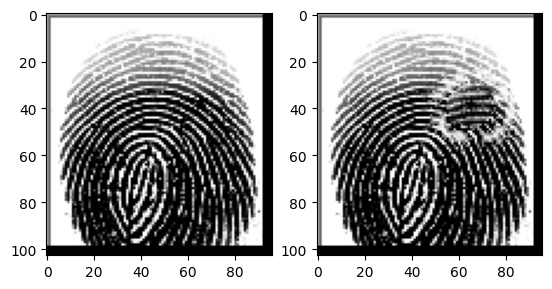

In [40]:
subject_folder_iter = Path.cwd().joinpath('data').joinpath('1').iterdir() 
file_1 = next(subject_folder_iter)
file_2 = next(subject_folder_iter)
print(file_1, file_2)
file_mat_1 = cv.imread(str(file_1))
file_mat_2 = cv.imread(str(file_2))
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(file_mat_1)
ax2.imshow(file_mat_2)

## Preprocessing

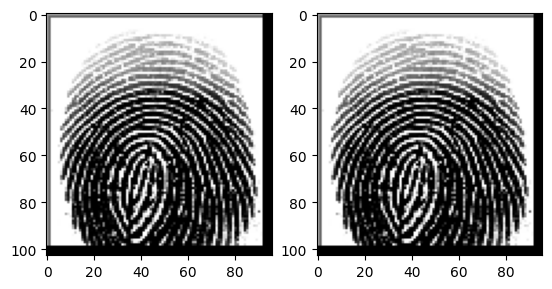

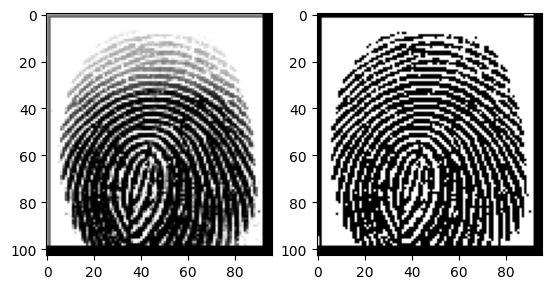

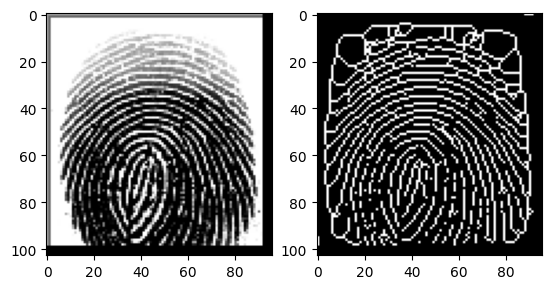

In [41]:
# fingerprint = cv.bitwise_not(file_mat_1)
fingerprint = file_mat_1
draw_compare(file_mat_1, fingerprint)
fingerprint_gray = cv.cvtColor(fingerprint, cv.COLOR_BGR2GRAY)
binarized_img = cv.adaptiveThreshold(fingerprint_gray,1, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
draw_compare(file_mat_1, binarized_img)
fingerprint_skeletonize = morph.skeletonize(binarized_img)
draw_compare(file_mat_1, fingerprint_skeletonize)

In [42]:
def preprocessing(file):
    fingerprint = file
    fingerprint_gray = cv.cvtColor(fingerprint, cv.COLOR_BGR2GRAY)
    binarized_img = cv.adaptiveThreshold(fingerprint_gray,1, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2)
    fingerprint_skeletonize = morph.skeletonize(binarized_img)
    return fingerprint_skeletonize

## Wyznaczanie minucji

(21, 158)

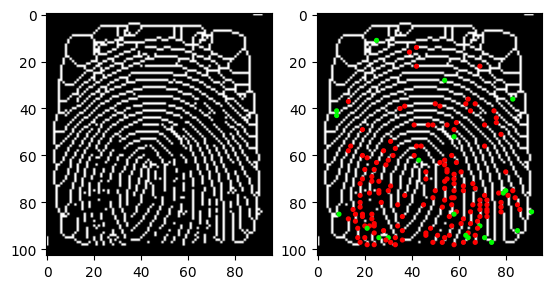

In [43]:
def find_minutae(fingerprint_skeletonize):
    bifurication_kernels = np.array(
            [
            [
                [1,0,0],
                [0,1,0],
                [1,0,0],
            ],
            [
                [1,0,1],
                [0,1,0],
                [0,0,0],
            ],
            [
                [0,0,1],
                [0,1,0],
                [0,0,1],
            ],
            [
                [0,0,0],
                [0,1,0],
                [1,0,1],
            ],
            [
                [0,1,0],
                [0,1,1],
                [0,0,0],
            ],
                    [
                [0,0,0],
                [0,1,1],
                [0,1,0],
            ],
                    [
                [0,0,0],
                [1,1,0],
                [0,1,0],
            ],
                    [
                [0,0,0],
                [0,1,1],
                [0,1,0],
            ]
            ]
        )
    end_begin_kernel = np.array(
    [
            [
                [0,1,0],
                [1,1,1],
                [0,1,0],
            ],
            [
                [1,0,1],
                [0,1,0],
                [1,0,1],
            ]
    ]
        )
    minutae = {
        'end_begin': [],
        'bifurcations':[],
    }
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(fingerprint_skeletonize, cmap='gray')
    ax2.imshow(fingerprint_skeletonize, cmap='gray')
    fingerprint_skeletonize = fingerprint_skeletonize.astype('uint8')
    found_minutiae_img = fingerprint_skeletonize.copy()
    # fingerprint_skeletonize = np.pad(fingerprint_gray, 1)
    X,Y = fingerprint_skeletonize.shape
    for x in range(1, X-1):
        for y in range(1, Y-1):
            # Get kernel for X,Y
            kernel_place = np.array(fingerprint_skeletonize[x-1:x+2,y-1:y+2])

            # Check if kernel has a value in the center
            if kernel_place[1,1]:
                number_of_values = len(np.flatnonzero(kernel_place))
                # Check for beginings and ends
                if number_of_values == 2:
                    if np.flatnonzero(np.bitwise_and(end_begin_kernel[0],kernel_place)).all() and np.flatnonzero(np.bitwise_and(end_begin_kernel[1],kernel_place)).all() :
                        minutae['end_begin'].append((y,x))
                        ax2.add_patch(Circle((y,x), radius=0.8, color='red'))
                #Check for bifurcations
                if number_of_values == 3:
                    for bif_kernel in bifurication_kernels:
                        if len(np.flatnonzero(np.bitwise_and(bif_kernel,kernel_place))) == 3:
                            minutae['bifurcations'].append((y,x))
                            ax2.add_patch(Circle((y,x), radius=0.8, color='lime'))
    return fig, minutae

fig, minutae = find_minutae(fingerprint_skeletonize)
fig.savefig('minutae.jpg')
len(minutae['bifurcations']), len(minutae['end_begin'])

## Obliczanie wektora cech

In [44]:
def calculate_distance_vector(minutae):
    def calculate_distance(point1, point2):
        return np.linalg.norm(np.array(point1) - np.array(point2))
    def calculate_distance_vector(points_array):
        distance_array = []
        for i in range(len(points_array)):
            for j in range(len(points_array)):
                if (i != j):
                    distance = calculate_distance(points_array[i], points_array[j])
                    if distance > 0:
                        distance_array.append(distance)
        return distance_array
    return np.array(calculate_distance_vector(minutae))

def calculate_statistics(distance_vector: np.ndarray):
    max = distance_vector.max()
    min = distance_vector.min()
    mean = distance_vector.mean()
    mid_val = np.median(distance_vector)
    return np.array((max, min, mean, mid_val))

distance_vector_begins = calculate_distance_vector(minutae['end_begin'])
statistics_begins = calculate_statistics(distance_vector_begins)

distance_vector_bif = calculate_distance_vector(minutae['bifurcations'])
statistics_bif = calculate_statistics(distance_vector_bif)

bif = np.array(minutae['bifurcations'])
begins = np.array(minutae['end_begin'])
all_minutae = np.concatenate((bif,begins))
distance_vector_all = calculate_distance_vector(all_minutae)
statistics_all = calculate_statistics(distance_vector_all)
np.concatenate((statistics_begins, statistics_bif, statistics_all))

array([ 90.69729875,   1.        ,  35.01829187,  34.43835072,
       100.8017857 ,   1.41421356,  48.08384195,  48.15068132,
       100.8017857 ,   1.        ,  36.64395925,  36.01388621])

In [45]:
def calculate_feature_vector(minutae):
    distance_vector_begins = calculate_distance_vector(minutae['end_begin'])
    statistics_begins = calculate_statistics(distance_vector_begins)

    distance_vector_bif = calculate_distance_vector(minutae['bifurcations'])
    statistics_bif = calculate_statistics(distance_vector_bif)

    bif = np.array(minutae['bifurcations'])
    begins = np.array(minutae['end_begin'])
    all_minutae = np.concatenate((bif,begins))
    distance_vector_all = calculate_distance_vector(all_minutae)
    statistics_all = calculate_statistics(distance_vector_all)
    feature_vector = np.concatenate((statistics_begins, statistics_bif, statistics_all))
    all_count = len(all_minutae)
    begins_to_bif_ratio = (len(begins)/len(bif))
    feature_vector = np.append(feature_vector, all_count)
    feature_vector = np.append(feature_vector, begins_to_bif_ratio)
    return feature_vector

calculate_feature_vector(minutae)

array([ 90.69729875,   1.        ,  35.01829187,  34.43835072,
       100.8017857 ,   1.41421356,  48.08384195,  48.15068132,
       100.8017857 ,   1.        ,  36.64395925,  36.01388621,
       179.        ,   7.52380952])

Wektor cech:
- maksymalna odleglosc miedzy poczatkami
- minimalna odleglosc miedzy poczatkami
- srednia odleglosc miedzy poczatkami
- mediana odleglosci miedzy poczatkami
- maksymalna odleglosc miedzy rozwidleniami
- minimalna odleglosc miedzy rozwidleniami
- srednia odleglosc miedzy rozwidleniami
- mediana odleglosci miedzy rozwidleniami
- maksymalna odleglosc miedzy minucjami
- minimalna odleglosc miedzy minucjami
- srednia odleglosc miedzy minucjami
- mediana odleglosci miedzy minucjami
- ilosc wszystkich minucji
- stosunek poczatkow/rozwidlen

## Klasyfikacja

### Dwie próbki dwa odciski palca

x:\STUDIA\biometry-masters-class\ps4\data\1\1__M_Left_index_finger.BMP x:\STUDIA\biometry-masters-class\ps4\data\2\2__F_Left_index_finger.BMP


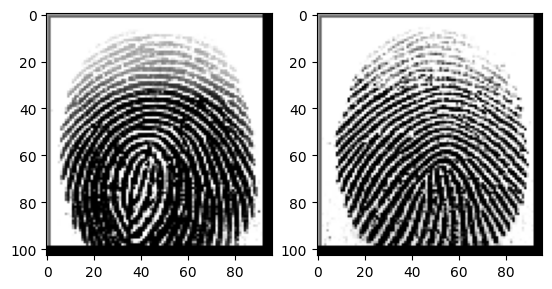

In [46]:
subject_folder_iter = Path.cwd().joinpath('data').joinpath('1').iterdir() 
file_1 = next(subject_folder_iter)
subject_folder_iter = Path.cwd().joinpath('data').joinpath('2').iterdir() 
file_2 = next(subject_folder_iter)
print(file_1, file_2)
file_mat_1 = cv.imread(str(file_1))
file_mat_2 = cv.imread(str(file_2))
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(file_mat_1)
ax2.imshow(file_mat_2)

(array([ 90.69729875,   1.        ,  35.01829187,  34.43835072,
        100.8017857 ,   1.41421356,  48.08384195,  48.15068132,
        100.8017857 ,   1.        ,  36.64395925,  36.01388621,
        179.        ,   7.52380952]),
 array([ 71.69379332,   1.        ,  25.39968785,  23.53720459,
        100.65783626,   1.41421356,  50.21070264,  53.50118857,
        100.65783626,   1.        ,  37.93561311,  34.525353  ,
         63.        ,   1.52      ]))

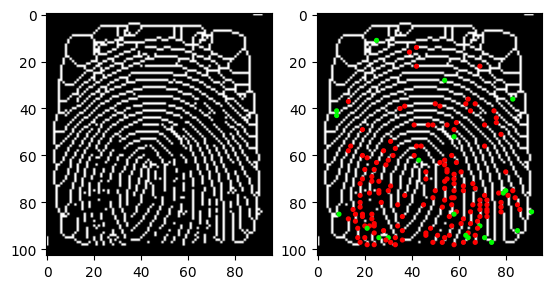

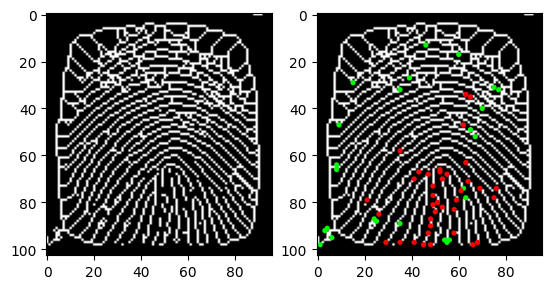

In [47]:
fingerprint_skeletonize1 = preprocessing(file_mat_1)
fig, minutae1 = find_minutae(fingerprint_skeletonize1)
fingerprint_skeletonize2 = preprocessing(file_mat_2)
fig, minutae2 = find_minutae(fingerprint_skeletonize2)

feature_vector1 = calculate_feature_vector(minutae1)
feature_vector2 = calculate_feature_vector(minutae2)
feature_vector1, feature_vector2

In [53]:
def calculate_accuracy(feature_vector1, feature_vector2):
    difference_arr = []
    for i in range(len(feature_vector1)):
        difference = 1 - (np.abs(feature_vector1[i] - feature_vector2[i]))/feature_vector1[i]
        difference_arr.append(difference)
    return np.array(difference_arr).mean()
print(f'{calculate_accuracy(feature_vector1, feature_vector2)*100}%')

98.66970630539659%


### Dwie próbki jednego odcisku

x:\STUDIA\biometry-masters-class\ps4\data\1\1__M_Left_index_finger.BMP x:\STUDIA\biometry-masters-class\ps4\data\1\1__M_Left_index_finger_CR.BMP


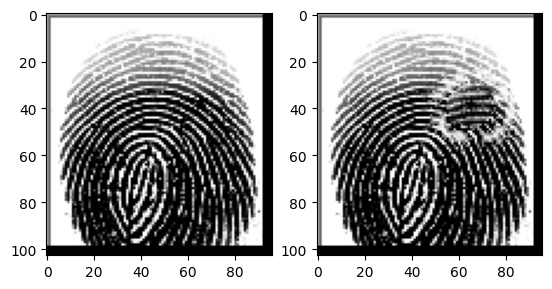

In [49]:
subject_folder_iter = Path.cwd().joinpath('data').joinpath('1').iterdir() 
file_1 = next(subject_folder_iter)
file_2 = next(subject_folder_iter)
print(file_1, file_2)
file_mat_1 = cv.imread(str(file_1))
file_mat_2 = cv.imread(str(file_2))
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(file_mat_1)
ax2.imshow(file_mat_2)

(array([ 90.69729875,   1.        ,  35.01829187,  34.43835072,
        100.8017857 ,   1.41421356,  48.08384195,  48.15068132,
        100.8017857 ,   1.        ,  36.64395925,  36.01388621,
        179.        ,   7.52380952]),
 array([ 90.69729875,   1.        ,  35.35932039,  34.88552709,
        100.8017857 ,   1.41421356,  48.95186096,  51.6139516 ,
        100.8017857 ,   1.        ,  37.14758691,  36.34556369,
        181.        ,   7.22727273]))

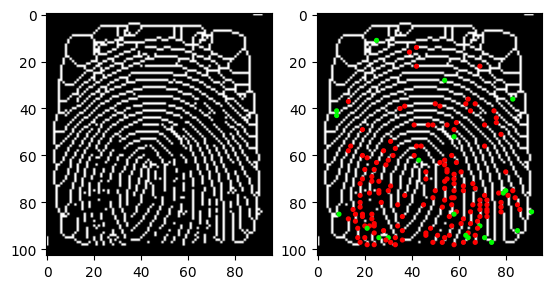

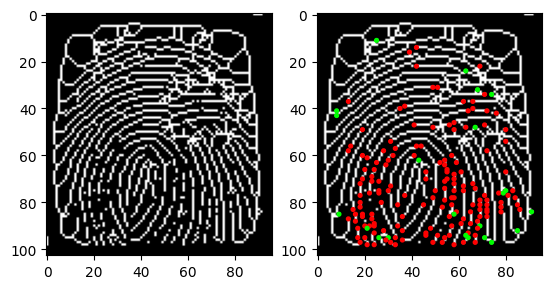

In [50]:
fingerprint_skeletonize1 = preprocessing(file_mat_1)
fig, minutae1 = find_minutae(fingerprint_skeletonize1)
fingerprint_skeletonize2 = preprocessing(file_mat_2)
fig, minutae2 = find_minutae(fingerprint_skeletonize2)

feature_vector1 = calculate_feature_vector(minutae1)
feature_vector2 = calculate_feature_vector(minutae2)
feature_vector1, feature_vector2

In [51]:
print(f'{calculate_accuracy(feature_vector1, feature_vector2)*100}%')

98.66970630539659%


# Zadanie 2

In [244]:
def prepare_train_set():
    train_set = []
    decision_set = []
    train_path = Path.cwd().joinpath('train')
    decision_map = {'begin_end': 1, 'bifurcation': 2, 'no_pattern': 3}
    for sub_dir in Path.iterdir(train_path):
        for path in Path.iterdir(sub_dir):
            file = str(path)
            image = cv.imread(str(file))
            image = cv.bitwise_not(image)
            gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
            _, gray = cv.threshold(gray, 128, 1, cv.THRESH_BINARY)
            train_set.append(np.ravel(gray))
            decision_set.append(str(sub_dir).split('\\')[-1])
    decision_set = [decision_map[x] for x in decision_set]
    return train_set, decision_set

In [245]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=100,solver='lbfgs',random_state=1)

train_set, decision_set = prepare_train_set()
classifier.fit(train_set, decision_set)
train_set, decision_set

([array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
         0, 0, 0], dtype=uint8),
  array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
         0, 0, 0], dtype=uint8),
  array([0, 0, 0, 1, 0, 0, 0

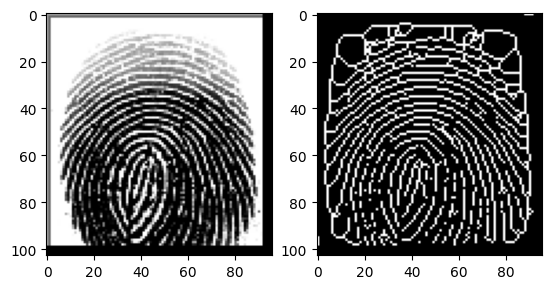

In [246]:
subject_folder_iter = Path.cwd().joinpath('data').joinpath('1').iterdir() 
file_1 = next(subject_folder_iter)
image1 = cv.imread(str(file_1))
fingerprint_skeletonize1 = preprocessing(image1)
draw_compare(image1, fingerprint_skeletonize1)

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
[1]
[[0 0 0 0 0]
 [0 0 0

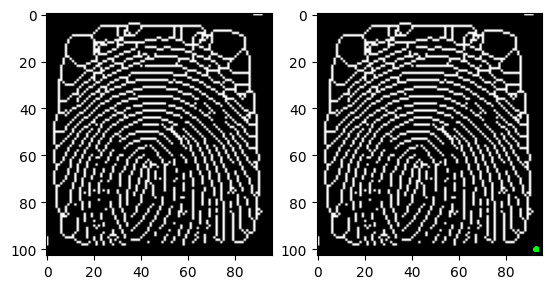

In [247]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(fingerprint_skeletonize1, cmap='gray')
ax2.imshow(fingerprint_skeletonize1, cmap='gray')
fingerprint_skeletonize1 = fingerprint_skeletonize1.astype('uint8')
X,Y = fingerprint_skeletonize1.shape
minutae = {
    'end_begin': [],
    'bifurcations':[],
}
for x in range(2, X-2):
    for y in range(2, Y-2):
        # Get kernel for X,Y
        kernel_place = np.array(fingerprint_skeletonize1[x-2:x+3,y-2:y+3])
        print(kernel_place)
        result = classifier.predict([np.ravel(kernel_place)])
        print(result)
        if result == 1:
            minutae['end_begin'].append((y,x))
        elif result == 2:
            minutae['bifurcations'].append((y,x))
minutae['end_begin'] =  minutae['end_begin'][0::100]
minutae['bifurcations'] =  minutae['bifurcations'][0::100]
for m in minutae['end_begin']:
    ax2.add_patch(Circle(m, radius=0.8, color='red'))
for m in minutae['bifurcations']:
    ax2.add_patch(Circle(m, radius=0.8, color='lime'))